Este script evalua distintos modelos para seleccionar uno en la etapa de optimizacion y modelacion

In [ ]:
# Data reading
# ==============================================================================
import numpy as np
import pandas as pd
import xarray as xr
import glob

# Graphics 
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Preprocessing and modeling
# ==============================================================================
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import ensemble
from sklearn import model_selection
from sklearn.kernel_ridge import KernelRidge
import statsmodels.api as sm

# Metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time

# Warnings configuration 
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [82]:
# Rutas de los datos y guardado de imagenes
path = 'D:/Documentos/Maestria/DATOS ERA5/ERA5/'
mlg = 'D:/Documentos/Maestria/MLG/'
save_imgs = mlg+'IMGS/'

In [3]:
# Lectura
data = xr.open_dataset(path+'DATASET_ERA5.nc')

Dado que se evaluan distintos modelos, se selecciona solo un año para reducir los tiempos de computo y recursos necesarios

In [4]:
dates_test = slice('2020-01-01','2020-12-31')
data = data.sel(time=dates_test)

Se selecciona el predictando y predictores. No se selecciona mn2t para notar mejor las diferencias en los modelos

In [5]:
hzn = 24  # Cantidad de horas a rezagar
Y = data.mn2t[hzn:]
X = data.drop(['mn2t'])
X = X.sel(time=data.time[:-hzn]) 
scaler = StandardScaler()

Funcion para preprocesamiento de los datos en los respectivos pixeles

In [6]:
def prepro(X, Y, i, j, t_sz):
    lat = X.latitude[i]
    lon = X.longitude[j]
    
    x_sub = X.sel(latitude = lat, longitude = lon)
    x_sub = x_sub.to_array()
    # - Invertir los ejer para que el arra sea de shape (n_samples, n_features)
    x_sub = np.swapaxes(x_sub, 0,1)
    y_sub = Y.sel(latitude = lat, longitude = lon).values
    # - Estandarizacion
    x_sub_s = scaler.fit_transform(x_sub)
    y_sub_s = scaler.fit_transform(y_sub.reshape(-1,1))
    y_sub_s = y_sub_s.reshape(y_sub.shape)
            
    #==================== Dividir los datos ==================== 
    # - Se evita usar shuffle dado que el orden de los datos es importante
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x_sub_s, y_sub_s, test_size=t_sz, shuffle = False)
    
    return x_train, x_test, y_train, y_test

## Metodos simples

In [7]:
# - instanciamiento
lmr = linear_model.Ridge()
knn = neighbors.KNeighborsRegressor()
#svm = svm.SVR()
clf = tree.DecisionTreeRegressor()

In [8]:
# - Arrays para salvar las metricas de los modelos
n_mod = 3
n_met = 4
lats = Y.latitude.shape[0]
lons = Y.longitude.shape[0]
metrics = np.zeros((n_mod, n_met, lats, lons))*np.nan

In [9]:
for i in range(Y.latitude.shape[0]):
    for j in range(Y.longitude.shape[0]):
        # - Con esta condicion se evitan las zonas enmascaradas
        if (np.isnan(Y[:,i,j]).sum())<10:
            #==================== Pre-Procesamiento ==================== 
            x_train, x_test, y_train, y_test = prepro(X, Y, i, j, 0.33)

            #======================================================
            #              Aplicacion de modelos
            #======================================================
            
            #==================== Linear Model ====================
            st_lmr = time.time()
            
            lmr_f = lmr.fit(x_train, y_train)
            y_pred = lmr.predict(x_test)
            
            lmr_score = lmr_f.score(x_train, y_train)
            metrics[0,0,i,j] = lmr_score
            lmr_r2 = r2_score(y_test, y_pred)
            metrics[0,1,i,j] = lmr_r2
            lmr_mse = mean_squared_error(y_test, y_pred, squared=False)
            metrics[0,2,i,j] = lmr_mse
            
            
            ed_lmr = time.time()
            tt_lmr = ed_lmr-st_lmr
            metrics[0,3,i,j] = tt_lmr
            
            #==================== KNN ====================
            st_knn = time.time()
            
            knn.fit(x_train,y_train)
            y_pred = knn.predict(x_test)
            
            knn_score = knn.score(x_train, y_train)
            metrics[1,0,i,j] = knn_score
            knn_r2 = r2_score(y_test, y_pred)
            metrics[1,1,i,j] = knn_r2
            knn_mse = mean_squared_error(y_test, y_pred, squared=False)
            metrics[1,2,i,j] = knn_mse
            
            
            ed_knn = time.time()
            tt_knn = ed_knn-st_knn
            metrics[1,3,i,j] = tt_knn
            
            #==================== SVM ====================
            # Nota: pequeños experimentos mostraron este como un modelo que
            # consume muchos recursos. Si se desea evaluar, descomentar estas lineas
            # y cambiar n_mod a 4 
            
            #st_svm = time.time()

            #svm.fit(x_train, y_train)
            #y_pred = svm.predict(x_test)
            
            #svm_score = svm.score(x_train, y_train)
            #metrics[2,0,i,j] = svm_score
            #svm_r2 = r2_score(y_test, y_pred)
            #metrics[2,1,i,j] = svm_r2
            #svm_mse = mean_squared_error(y_test, y_pred, squared=False)
            #metrics[2,2,i,j] = svm_mse
            
            #ed_svm = time.time()
            #tt_svm = ed_svm-st_svm
            #metrics[2,3,i,j] = tt_svm
            
            #==================== Decision Tree ====================
            st_clf = time.time()
            
            clf = clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            
            tre_score = clf.score(x_train, y_train)
            metrics[2,0,i,j] = tre_score
            tre_r2 = r2_score(y_test, y_pred)
            metrics[2,1,i,j] = tre_r2
            tre_mse = mean_squared_error(y_test, y_pred, squared=False)
            metrics[2,2,i,j] = tre_mse
            
            ed_clf = time.time()
            tt_clf = ed_clf-st_clf
            metrics[2,3,i,j] = tt_clf
            
            #print(lat.values,lon.values)

In [10]:
# Guardado de las metricas
data_metrics = xr.DataArray(data = metrics, 
                            dims = ['model', 'metric', 'lat', 'lon'], 
                            coords = dict(model=['lmr', 'knn', 'svm', 'tre'], 
                                          metric=['r2_train', 'r2_val', 'mse_val','pc_time'],
                                          lat=Y.latitude.values, 
                                          lon=Y.longitude.values)
                           )

In [11]:
data_metrics.to_netcdf(mlg+str(hzn)+'_pre_metrics.nc')

## Modelos avanzados

In [12]:
rf  = RandomForestRegressor()
bag = BaggingRegressor()
mlp = MLPRegressor()

In [13]:
# - Arrays to save models metrics
n_mod = 3
n_met = 4
lats = Y.latitude.shape[0]
lons = Y.longitude.shape[0]
metrics_ad = np.zeros((n_mod, n_met, lats, lons))*np.nan

In [14]:
for i in range(Y.latitude.shape[0]):
    for j in range(Y.longitude.shape[0]):
        if (np.isnan(Y[:,i,j]).sum())<10:
            x_train, x_test, y_train, y_test = prepro(X, Y, i, j, 0.33)
            
            #======================================================
            #             Aplicacion de Modelos
            #======================================================
            
            #==================== Random forest ====================
            st_rf = time.time()
            
            rf = rf.fit(x_train, y_train)
            y_pred = rf.predict(x_test)
            
            rf_score = rf.score(x_train, y_train)
            metrics_ad[0,0,i,j] = rf_score
            rf_r2 = r2_score(y_test, y_pred)
            metrics_ad[0,1,i,j] = rf_r2
            rf_mse = mean_squared_error(y_test, y_pred, squared=False)
            metrics_ad[0,2,i,j] = rf_mse
            
            
            ed_rf = time.time()
            tt_rf = ed_rf-st_rf
            metrics_ad[0,3,i,j] = tt_rf
            
            #==================== Bagging ====================
            st_bag = time.time()
            
            bag = bag.fit(x_train, y_train)
            y_pred = bag.predict(x_test)
            
            bag_score = bag.score(x_train, y_train)
            metrics_ad[1,0,i,j] = bag_score
            bag_r2 = r2_score(y_test, y_pred)
            metrics_ad[1,1,i,j] = bag_r2
            bag_mse = mean_squared_error(y_test, y_pred, squared=False)
            metrics_ad[1,2,i,j] = bag_mse
            
            
            ed_bag = time.time()
            tt_bag = ed_bag-st_bag
            metrics_ad[1,3,i,j] = tt_bag
            
            #==================== Multy Layer Perceptron ====================
            st_mlp = time.time()
            
            mlp = mlp.fit(x_train, y_train)
            y_pred = mlp.predict(x_test)
            
            mlp_score = mlp.score(x_train, y_train)
            metrics_ad[2,0,i,j] = mlp_score
            mlp_r2 = r2_score(y_test, y_pred)
            metrics_ad[2,1,i,j] = mlp_r2
            mlp_mse = mean_squared_error(y_test, y_pred, squared=False)
            metrics_ad[2,2,i,j] = mlp_mse
            
            
            ed_mlp = time.time()
            tt_mlp = ed_mlp-st_mlp
            metrics_ad[2,3,i,j] = tt_mlp

In [15]:
# Guardado de modelos
data_metrics_ad = xr.DataArray(data = metrics_ad, 
                               dims = ['model', 'metric', 'lat', 'lon'], 
                               coords = dict(model=['rf', 'bag', 'mlp'], 
                                             metric=['r2_train', 'r2_val', 'mse_val','pc_time'],
                                             lat=Y.latitude.values, 
                                             lon=Y.longitude.values)
                              )

In [16]:
data_metrics_ad.to_netcdf(mlg+str(hzn)+'_pre_metrics_advanced.nc')

## Pruebas con tensorflow

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [56]:
# Another model, Functional API
def build_model():
    model = keras.Sequential([
        layers.Dense(12, activation='relu', input_shape=[len(x_train[1])],kernel_initializer='VarianceScaling'),
        layers.Dense(12, activation='tanh',kernel_initializer='VarianceScaling'),
        layers.Dense(1)
    ])
    
    optimizer = keras.optimizers.RMSprop(0.0001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

In [57]:
model = build_model()

In [58]:
#y_pred = model.predict(x_test)

In [59]:
#r2_score(y_test, y_pred)

In [60]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train,
                    y_train,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
...............................................................................

In [61]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

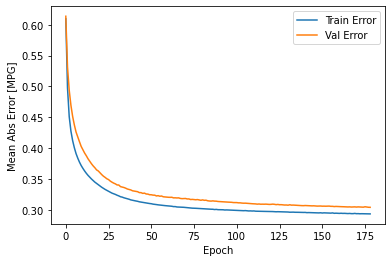

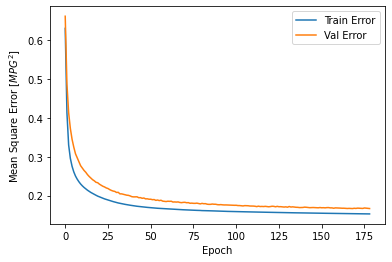

In [62]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)